In [1]:
#make a mesh of the object, easy
#write code to fit that model to video, hard
#
#median filter to get rid of debris
#color filter to get bright edges
#
#ffmpeg command:
#ffmpeg -i d8_7-15_02.mp4 -ss 00:00:0.000 -vframes 600 \WORK\Research\Summer-2021_SpinTracking\painted_frames\dice%04d.png -hide_banner

In [175]:
#start of Professor's code
import cv2

from __future__ import division, unicode_literals, print_function  
import numpy as np
import matplotlib.pyplot as plt
import pims  # image reading routines
import os  #operating system

import pandas as pd

import trackpy as tp
#http://soft-matter.github.io/trackpy/v0.5.0/
from scipy import ndimage  # for shifting images

from pims import pipeline  # for video frames
from pims import Frame

from scipy.signal import savgol_filter  # for smoothing

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from track_lib import  *  # some subroutines writting specifically for marble tracking

In [32]:
# read in frames
frames_dir = '/WORK/Research/Summer-2021_SpinTracking/painted_frames/dice*.png'
framesrgb = pims.open(frames_dir)  # this is d8_6-16_04.mp4 video that was processed with 
#ffmpeg -i d8_6-16_04.mp4   -ss 00:00:0.000 -vframes 600 dice%04d.png -hide_banner

print('number of frames  ', len(framesrgb))  # number of frames

number of frames   319


Frame([[34, 34, 38, ..., 52, 44, 46],
       [39, 37, 39, ..., 52, 40, 40],
       [35, 37, 40, ..., 44, 41, 37],
       ...,
       [48, 49, 44, ..., 11, 11,  9],
       [43, 50, 43, ...,  6,  8,  7],
       [52, 50, 44, ...,  9, 12, 10]], dtype=uint8)
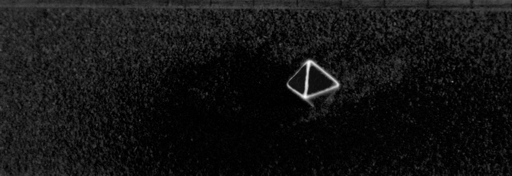

In [34]:
i0=0
i1=440  # cutting the bottom
j0=0
j1=1280

j=140
framesrgb[j][i0:i1,j0:j1,0]

#end of Professor's code

#### Corner detection using ORB

In [6]:
img = cv2.imread("dice0182.png", 0)

#DOESNT WORK
#gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#corners = cv2.goodFeaturesToTrack(gray, 40, 0.01, 10)
#corners = np.int0(corners)

#for i in corners:
#    x,y = i.ravel()
#    cv2.circle(img,(x,y),3,[0,255,0],-1)


##NOPE
##detector = cv2.FastFeatureDetector_create(20)
##kp = detector.detect(img, None)

##img2 = cv2.drawKeypoints(img, kp, None, flags=0)


###WORKS BUT LIMITED, 4 CORNERS DETECTED
orb = cv2.ORB_create(35)
kp, des = orb.detectAndCompute(img, None)

img2 = cv2.drawKeypoints(img, kp, None, flags=0)

#gets the positions of the keypoints
#pts = cv2.KeyPoint_convert(kp)

cv2.imshow("Corners", img2)
cv2.waitKey(0)

-1

#### Test of Canny Edge

In [12]:
#read in image
img = cv2.imread("dice0182.png")

#filters to help with edge detection
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (7,7), 0)

#actual edge detection
imgCanny = cv2.Canny(img, 150, 200)

#display
cv2.imshow("Canny Image", imgCanny)
cv2.waitKey(0)

#looks good for this image

113

#### Canny on Video

In [179]:
#the video the frame came from
#oh shit this thing works

#reads in the video
cap = cv2.VideoCapture('d8_7-15_02.mp4')

while(cap.isOpened()):
    #reads in frames
    ret, frame = cap.read()
    #hsv = cv2.convertColor(frame, cv2.COLOR_BGR2HSV)
    
    #filters to help with edge detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    
    #actual edge detection
    canny = cv2.Canny(frame, 150, 200)
    
    #oh shit can we apply ORB on the video??
    #orb = cv2.ORB_create(50)
    #kp, des = orb.detectAndCompute(frame, None)

    #orb_vid = cv2.drawKeypoints(frame, kp, None, flags=0)
    #orb_vid2 = cv2.drawKeypoints(canny, kp, None, flags=0)

    #cv2.imshow("Corners", orb_vid)
    #cv2.imshow("More Corners", orb_vid2)
    #good lord it does work
    
    #cv2.imshow('frame',frame)
    cv2.imshow('Canny', canny)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-vi271kac\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


#### Method to help crop frames to focus on dice

In [8]:
from PIL import Image
import statistics

def green_pixels(image_name):
    
    # Sets the values for the range of color
    r_min = 5
    r_max = 20
    g_min = 80
    g_max = 225
    b_min = 80
    b_max = 220

    green_pixels = set()

    img = Image.open(image_name)
    rgb = img.convert('RGB')
    
    #if the frame has pixels in the range of color, it gets added to the set
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            r, g, b = rgb.getpixel((x, y))
            if r >= r_min and r <= r_max and b >= b_min and b <= b_max and g >= g_min and g <= g_max:
                green_pixels.add((x,y))

    #gets values for x and y specifics
    xs = [x[0] for x in green_pixels]
    ys = [y[1] for y in green_pixels]

    #gets medians for each 
    xmed = statistics.median(xs)
    ymed = statistics.median(ys)
    
    #makes them ints 
    xmed = int(xmed)
    ymed = int(ymed)
    
    return xmed, ymed

In [5]:
#tests!
x, y = green_pixels('dice0182.png')
print(x, y)

974 193


In [9]:
#img_names = [f'dice{i}' for i in range(319)]

#creates a set to store filenames
imgs = []

#generates a list of the appropriate filenames
for i in range(1, 320):
    if i in range(1, 10):
        imgs.append(f'painted_frames/dice000{i}.png')
    if i in range(10, 100):
        imgs.append(f'painted_frames/dice00{i}.png')
    if i in range(100, 320):
        imgs.append(f'painted_frames/dice0{i}.png')
    

#### Video writer for cropped frames; stop running this idiot

In [10]:
#stuff to write the movie
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_movie = cv2.VideoWriter('d8_painted.mp4', fourcc, 60, (170, 170))

#made a general range to reduce code runtime a bit
for i in range(70, 250):
    xmed, ymed = green_pixels(imgs[i])
    
    #bounds of the cropped frames
    xmin = xmed - 70
    xmax = xmed + 100
    ymin = ymed - 85
    ymax = ymed + 85
    
    img = cv2.imread(imgs[i])
    
    cropped = img[ymin:ymax, xmin:xmax]
    output_movie.write(cropped)

output_movie.release()

#### Canny for cropped frames video

In [15]:
#reads in the video
cap = cv2.VideoCapture('d8_painted.mp4')

while(cap.isOpened()):
    #reads in frames
    ret, frame = cap.read()
    #hsv = cv2.convertColor(frame, cv2.COLOR_BGR2HSV)
    
    #filters to help with edge detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    
    #actual edge detection
    canny = cv2.Canny(frame, 150, 200)
    
    #orb doesn't work that well here, but the edges look fine
    orb = cv2.ORB_create(50)
    kp, des = orb.detectAndCompute(frame, None)
    
    #orb_vid = cv2.drawKeypoints(frame, kp, None, flags=0)
    orb_vid2 = cv2.drawKeypoints(canny, kp, None, flags=0)

    #cv2.imshow("Corners", orb_vid)
    cv2.imshow("More Corners", orb_vid2)
    
    #cv2.imshow('Canny', canny)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-vi271kac\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [163]:
from pyquaternion import Quaternion
from itertools import combinations

# making a class for the dice d8 
class dice_d8():
    # make a d8 with length 1 between top and bottom verticles 
    # and length 1 between opposite equatorial vertices
    def __init__(self):
        self.nv = 6  # number of vertices
        self.nf = 8  # number of faces
        self.vertices = np.zeros((self.nv,3))  # list of 6 points, each with three coordinates
        self.faces = np.zeros((self.nf,3),dtype=int)  # 8 faces each listing 3 vertices
        hfac = 2  # gives length 1 between opposite vertices  on equator
        vfac = 2  # gives length 1 between opposite vertices on poles
        self.vertices[0,:] = np.array([ 0, 0, 1])/vfac  # top
        self.vertices[1,:] = np.array([ 1, 0, 0])/hfac  # equatorial
        self.vertices[2,:] = np.array([ 0, 1, 0])/hfac  # equatorial
        self.vertices[3,:] = np.array([-1, 0, 0])/hfac  # equatorial
        self.vertices[4,:] = np.array([ 0,-1, 0])/hfac  # equatorial
        self.vertices[5,:] = np.array([ 0, 0,-1])/vfac  # bottom
        
        self.faces[0,:] = np.array([0,1,2])  # order is important
        self.faces[1,:] = np.array([0,2,3])
        self.faces[2,:] = np.array([0,3,4])
        self.faces[3,:] = np.array([0,4,1])
        self.faces[4,:] = np.array([5,2,1])
        self.faces[5,:] = np.array([5,3,2])
        self.faces[6,:] = np.array([5,4,3])
        self.faces[7,:] = np.array([5,1,4])
        # these have been checked for outward orientation (but not 100% sure yet)
        
        # compute face normal unit vectors
        self.face_normals =  np.zeros((self.nf,3)) 
        self.compute_face_normals()
        
        # compute face centroid positions
        self.face_centroids = np.zeros((self.nf,3)) 
        self.compute_face_centroids()
        
        # find out whether the vertices are visible, viewer assumed to be on the +z axis direction
        self.v_visible  = np.zeros(self.nv,dtype=int) 
        self.compute_isvisible()
        
        # find out whether the edges are visible, viewer assumed to be on the +z axis direction
        #self.e_visible = np.zeros(self.nf,dtype=int)
        #self.compute_edgevisible()
    
    # loop over faces to compute face normal vectors
    def compute_face_normals(self):
        for iface in range(self.nf):
            iv0 = self.faces[iface,0]  # this is an index for a vertex
            iv1 = self.faces[iface,1]
            iv2 = self.faces[iface,2]
            v0 = self.vertices[iv0,:]  # these are the three vertices
            v1 = self.vertices[iv1,:]
            v2 = self.vertices[iv2,:]
            dv01 = v1-v0  # edge directions 
            dv12 = v2-v1 
            nvec = cross_prod_2vecs(dv01,dv12)  # compute cross product
            nvec/= len_vec(nvec)  # normalize 
            self.face_normals[iface,:] = nvec
     
    # compute the centroid of each face
    def compute_face_centroids(self):
        for iface in range(self.nf):
            iv0 = self.faces[iface,0]  # this is an index for a vertex
            iv1 = self.faces[iface,1]
            iv2 = self.faces[iface,2]
            v0 = self.vertices[iv0,:]  # these are the three vertices
            v1 = self.vertices[iv1,:]
            v2 = self.vertices[iv2,:]
            vc = (v0+v1+v2)/3.0  # centroid
            self.face_centroids[iface,:] = vc
        
    # compute and return center of mass coordinate position
    def com(self):
        nv = len(self.vertices)
        xcom = np.sum(np.squeeze(self.vertices[:,0]))/nv
        ycom = np.sum(np.squeeze(self.vertices[:,1]))/nv
        zcom = np.sum(np.squeeze(self.vertices[:,2]))/nv
        return np.array([xcom,ycom,zcom])
    
    # rotate the dice by angle phi in radians about r_axis using a quaturnion
    # rotate about the center of mass 
    def rotate(self,r_axis,phi):
        q = Quaternion(axis=r_axis, angle=phi) # phi in radians
        nv = len(self.vertices)
        com_position  = self.com() #compute center of mass 
        for i in range(nv):
            v = np.squeeze(self.vertices[i,:]) - com_position  # a vertex w.r.t to center of mass
            v = q.rotate(v)  # rotate it with the quaturnion
            v += com_position # restore center of mass position
            self.vertices[i,:] = v   # replace with rotated vertex
        self.compute_face_normals()  # update face normal vectors
        self.compute_face_centroids() # update face centroids
        self.compute_isvisible()  # update visibility of vertices
    
    # are vertices visible from +z direction of viewing?
    # this routine seems to work now
    # vertex is assumed visible if one face that it is connect to 
    #    is lit with illumination coming from +z
    # we find out if a face is lit/visible if the face normal has a +z component
    def compute_isvisible(self):
        self.v_visible *=0  # reset to zero
        for iface in range(self.nf):
            if (self.face_normals[iface,2] >= 0):  # sun lit
                iv0 = self.faces[iface,0]  # this is an index for a vertex
                iv1 = self.faces[iface,1]
                iv2 = self.faces[iface,2]
                self.v_visible[iv0]=1
                self.v_visible[iv1]=1
                self.v_visible[iv2]=1
    
    # reset to initia conditions
    def reset(self):
        self.__init__()
                                  

# compute cross product of C=A X B for 3D vectors A,B, return C
def cross_prod_2vecs(A,B):
    C0 = A[1]*B[2] - A[2]*B[1]
    C1 = A[2]*B[0] - A[0]*B[2]
    C2 = A[0]*B[1] - A[1]*B[0]
    return np.array([C0,C1,C2])

# return the length of a vector
def len_vec(A):
    r2=0.0
    for i in range(3):
        r2 += A[i]**2
    return np.sqrt(r2)


# plot the edges of all the faces as a blue wireframe    
# arguments:
#   ax is axis for plotting
#   dice  (class dice_d8)
def plt_edges(ax,dice):
    nf = len(dice.faces)
    f = dice.faces
    v = dice.vertices
    cc = 'skyblue'
    for i in range(nf):
        if (dice.face_normals[i,2] >= 0):
            iv0 = f[i,0]  # this is an index for a vertex
            iv1 = f[i,1]
            iv2 = f[i,2]
            v0x = v[iv0,0]; v0y = v[iv0,1]
            v1x = v[iv1,0]; v1y = v[iv1,1]
            v2x = v[iv2,0]; v2y = v[iv2,1]
        
            ax.plot([v0x,v1x],[v0y,v1y],'-',color=cc)
            ax.plot([v1x,v2x],[v1y,v2y],'-',color=cc)
            ax.plot([v0x,v2x],[v0y,v2y],'-',color=cc)
            
# plot the face normal vectors as arrows
# this is to check the directions and face orientations
# arrows are orange if z component is positive, brown otherwise
def plt_face_normals(ax,dice):  
    nf = len(dice.faces)
    n = dice.face_normals
    fc = dice.face_centroids
    xvals = np.squeeze(fc[:,0])
    yvals = np.squeeze(fc[:,1])
    dxvals = np.squeeze(n[:,0])
    dyvals = np.squeeze(n[:,1])
    dzvals = np.squeeze(n[:,2])
    ii = dzvals >= 0
    ax.quiver(xvals[ii],yvals[ii],dxvals[ii],dyvals[ii],color='orange')
    #ii = dzvals < 0
    #ax.quiver(xvals[ii],yvals[ii],dxvals[ii],dyvals[ii],color='brown')
    
# plot visible vertices  
# plot vertex poles as red, equatorial vertex points in green
def plt_visible_vertices(ax,dice):
    v = dice.vertices
    xvals = np.squeeze(v[:,0])
    yvals = np.squeeze(v[:,1])
    ii = (dice.v_visible >0)  # visible vertices
    red_vertices = np.array([True, False, False, False, False, True])
    green_vertices = np.logical_not(red_vertices)
    ii_red = (ii & red_vertices)
    ii_green = (ii & green_vertices)
    ax.plot(xvals[ii_green],yvals[ii_green],'go')  # plot equatorial points in green
    ax.plot(xvals[ii_red],yvals[ii_red],'ro')  # plot poles as red

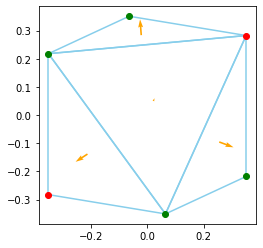

In [174]:
# tests!
dice = dice_d8()
theta = 1*np.pi/2;  lat = np.pi/4
r_axis = np.array([np.cos(theta)*np.sin(lat),np.sin(theta)*np.sin(lat),np.cos(lat)])
phi = 1.7
dice.rotate(r_axis,phi)  # rotate the dice and display
#meshplot.plot(dice.vertices, dice.faces)
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.set_aspect('equal')
plt_edges(ax,dice)  # display edges as a blue wireframe
plt_face_normals(ax,dice)  # display face normals at face centroids
plt_visible_vertices(ax,dice)  # only plot visible vertices
# looks ok